In [1]:
import pandas as pd
import FINE as fn

import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2

In [2]:
def dsm_test_esM():
    """
    Generate a simple energy system model with one node, two fixed generators and one load time series for testing
    demand side management functionality.
    """
    # load without dsm
    now = pd.Timestamp.now().round('h')
    number_of_time_steps = 24+11
    #t_index = pd.date_range(now, now + pd.DateOffset(hours=number_of_timeSteps - 1), freq='h')
    t_index = range(number_of_time_steps)
    load_without_dsm = pd.Series([80.] * number_of_time_steps, index=t_index)

    timestep_up = 10
    timestep_down = 20
    load_without_dsm[timestep_up:timestep_down] += 40.

    time_shift = 3
    cheap_capacity = 100.
    expensive_capacity = 20.

    # set up energy model
    esM = fn.EnergySystemModel(locations={'location'},
                               commodities={'electricity'},
                               numberOfTimeSteps=number_of_time_steps,
                               commodityUnitsDict={'electricity': r'MW$_{el}$'},
                               hoursPerTimeStep=1, costUnit='1 Euro',
                               lengthUnit='km',
                               verboseLogLevel=0)
    esM.add(fn.Source(esM=esM, name='cheap', commodity='electricity', hasCapacityVariable=False,
                      operationRateMax=pd.Series(cheap_capacity, index=t_index), opexPerOperation=25))
    esM.add(fn.Source(esM=esM, name='expensive', commodity='electricity', hasCapacityVariable=False,
                      operationRateMax=pd.Series(expensive_capacity, index=t_index), opexPerOperation=50))
    esM.add(fn.Source(esM=esM, name='back-up', commodity='electricity', hasCapacityVariable=False,
                      operationRateMax=pd.Series(1000, index=t_index), opexPerOperation=1000))

    return esM, load_without_dsm, timestep_up, timestep_down, time_shift, cheap_capacity


In [3]:
dsm_test_esM_ = dsm_test_esM()

In [4]:
"""
Given a one-node system with two generators, check whether the load and generation is shifted correctly in both
directions with and without demand side management.
"""

esM_without, load_without_dsm, timestep_up, timestep_down, time_shift, cheap_capacity = dsm_test_esM_

esM_without.add(fn.Sink(esM=esM_without, name='load', commodity='electricity',
                        hasCapacityVariable=False, operationRateFix=load_without_dsm))

esM_without.optimize(timeSeriesAggregation=False, solver='glpk')  # without dsm

generator_outputs = esM_without.componentModelingDict['SourceSinkModel'].operationVariablesOptimum

# benchmark generation without dsm
cheap_without_dsm = load_without_dsm.clip(0, cheap_capacity).copy()
cheap_without_dsm.name = ('cheap', 'location')
expensive_without_dsm = load_without_dsm - cheap_without_dsm
expensive_without_dsm.name = ('expensive', 'location')

Declaring sets, variables and constraints for SourceSinkModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.0156 sec)

Declaring shared potential constraint...
		(0.0000 sec)

Declaring commodity balances...
		(0.0000 sec)

Declaring objective function...
		(0.0000 sec)

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write C:\Users\L1DDC~1.WEL\AppData\Local\Temp\tmp8ugebsxi.glpk.raw --wglp
 C:\Users\L1DDC~1.WEL\AppData\Local\Temp\tmpjv9l6jih.glpk.glp --cpxlp C:\Users\L1DDC~1.WEL\AppData\Local\Temp\tmpoq41kujj.pyomo.lp
Reading problem data from 'C:\Users\L1DDC~1.WEL\AppData\Local\Temp\tmpoq41kujj.pyomo.lp'...
176 rows, 141 columns, 281 non-zeros
1062 lines were read
Writing problem data to 'C:\Users\L1DDC~1.WEL\AppData\Local\Temp\tmpjv9l6jih.glpk.glp'...
847 lines were written
GLPK Simplex Optimizer, v4.65
176 rows, 141 columns, 281 non-zeros
Preprocessing...
25 rows, 50 columns, 50 non-zeros
Scaling...
 A: min|aij| =  1.0

In [5]:
print((generator_outputs.loc[('cheap', 'location')] == cheap_without_dsm).all())
print((generator_outputs.loc[('expensive', 'location')] == expensive_without_dsm).all())

True
True


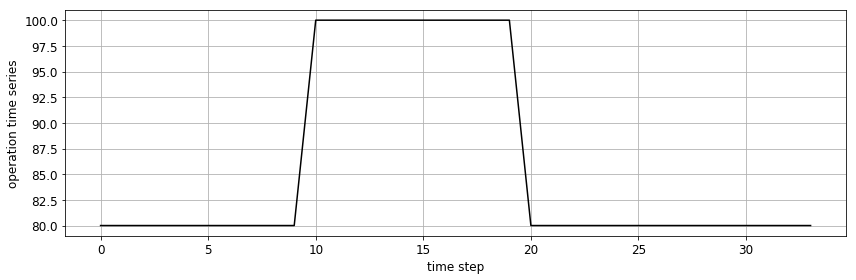

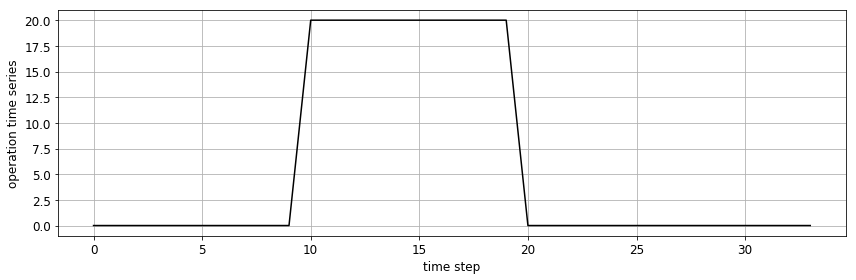

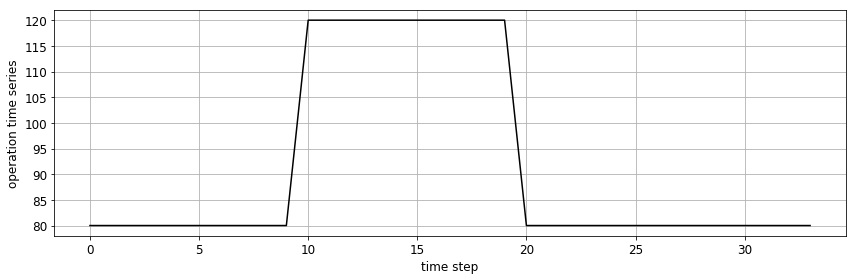

In [6]:
fig, ax = fn.plotOperation(esM_without,'cheap','location')
fig, ax = fn.plotOperation(esM_without,'expensive','location')
fig, ax = fn.plotOperation(esM_without,'load','location')

In [7]:
# add DSM
dsm_test_esM_ = dsm_test_esM()
tFwd = 3
tBwd = 3
esM_with = dsm_test_esM_[0]

esM_with.add(fn.DemandSideManagement(esM=esM_with, name='flexible demand', commodity='electricity',
                                     hasCapacityVariable=False, tFwd=tFwd, tBwd=tBwd,
                                     operationRateFix=load_without_dsm, opexShift=1,
                                     shiftDownMax=10, shiftUpMax=10))

esM_with.cluster(numberOfTimeStepsPerPeriod=1, numberOfTypicalPeriods=25)
esM_with.optimize(timeSeriesAggregation=True, solver='gurobi')  # with dsm

generator_outputs = esM_with.componentModelingDict["SourceSinkModel"].operationVariablesOptimum
esM_load_with_DSM = esM_with.componentModelingDict['DSMModel'].operationVariablesOptimum

# benchmark generation and load with dsm
expensive_with_dsm = expensive_without_dsm.copy()
expensive_with_dsm[timestep_up:timestep_up + time_shift] -= 10
expensive_with_dsm[timestep_down - time_shift:timestep_down] -= 10
expensive_with_dsm.name = ('expensive', 'location')

cheap_with_dsm = cheap_without_dsm.copy()
cheap_with_dsm[timestep_up - time_shift:timestep_up] += 10
cheap_with_dsm[timestep_down:timestep_down + time_shift] += 10
cheap_with_dsm.name = ('cheap', 'location')

load_with_dsm = load_without_dsm.copy()
load_with_dsm[timestep_up - time_shift:timestep_up] += 10
load_with_dsm[timestep_up:timestep_up + time_shift] -= 10
load_with_dsm[timestep_down - time_shift:timestep_down] -= 10
load_with_dsm[timestep_down:timestep_down + time_shift] += 10
load_with_dsm.name = ('flexible demand', 'location')

e:\models\fine_gitlab\fine\FINE\subclasses\storageExt.py:73: UserWarning: Warning only relevant when time series aggregation is used in optimization:
Setting the stateOfChargeOpRateMax parameter might lead to unwanted modeling behavior
and should be handled with caution.
  + 'and should be handled with caution.')
e:\models\fine_gitlab\fine\FINE\subclasses\storageExt.py:73: UserWarning: Warning only relevant when time series aggregation is used in optimization:
Setting the stateOfChargeOpRateMax parameter might lead to unwanted modeling behavior
and should be handled with caution.
  + 'and should be handled with caution.')
e:\models\fine_gitlab\fine\FINE\subclasses\storageExt.py:73: UserWarning: Warning only relevant when time series aggregation is used in optimization:
Setting the stateOfChargeOpRateMax parameter might lead to unwanted modeling behavior
and should be handled with caution.
  + 'and should be handled with caution.')
e:\models\fine_gitlab\fine\FINE\subclasses\storageExt.p


Clustering time series data with 25 typical periods and 1 time steps per period...
		(0.4701 sec)

Time series aggregation specifications:
Number of typical periods:25, number of time steps per periods:1

Declaring sets, variables and constraints for SourceSinkModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.0000 sec)

Declaring sets, variables and constraints for StorageExtModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.0469 sec)

Declaring sets, variables and constraints for DSMModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.1159 sec)

Declaring shared potential constraint...
		(0.0000 sec)

Declaring commodity balances...
		(0.0000 sec)

Declaring objective function...
		(0.0156 sec)

Academic license - for non-commercial use only
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Changed value of parameter logfile to 
   Prev: gurobi.log  Default: 
Ch

In [8]:
print((generator_outputs.loc[('cheap', 'location')] == cheap_with_dsm).all())
print((generator_outputs.loc[('expensive', 'location')] == expensive_with_dsm).all())
print((esM_load_with_DSM.loc[('flexible demand', 'location')] == load_with_dsm).all())

True
True
True


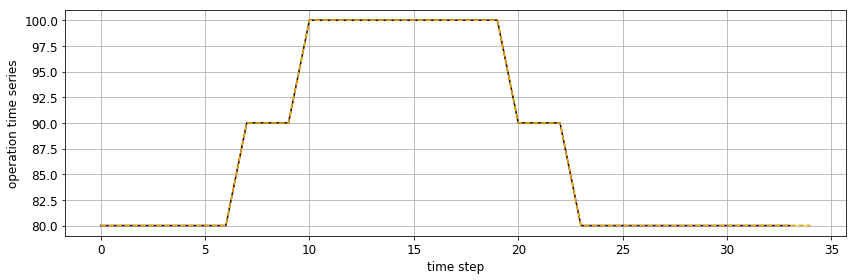

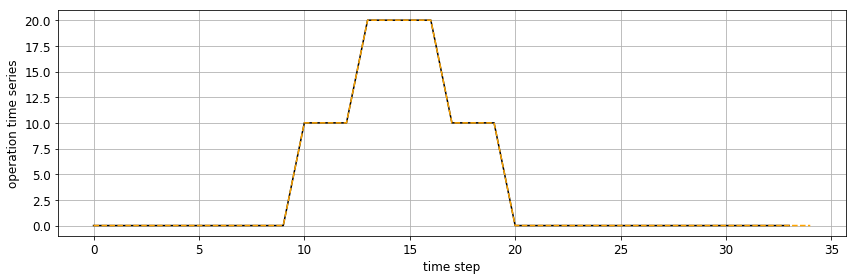

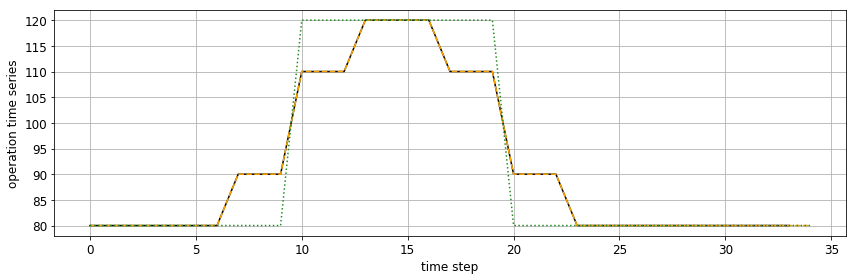

In [9]:
fig, ax = fn.plotOperation(esM_with,'cheap','location')
ax.plot(cheap_with_dsm, color='orange',linestyle='--')
fig, ax = fn.plotOperation(esM_with,'expensive','location')
ax.plot(expensive_with_dsm, color='orange',linestyle='--')
fig, ax = fn.plotOperation(esM_with,'flexible demand','location')
ax.plot(load_with_dsm, color='orange',linestyle='--')
ax.plot(load_without_dsm, color='forestgreen',linestyle=':')

In [10]:
esM_with.componentModelingDict['DSMModel'].operationVariablesOptimum

,,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
flexible demand,location,80.0,80.0,80.0,80.0,80.0,80.0,80.0,90.0,90.0,90.0,...,80.0,80.0,80.0,80.0,80.0,80.0,80.0,80.0,80.0,80.0


In [11]:
c = esM_with.componentModelingDict['StorageExtModel'].chargeOperationVariablesOptimum
c

,,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
flexible demand_0,location,0.0,0.0,0.0,0.0,80.0,0.0,0.0,0.0,10.0,0.0,...,80.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0,0.0,0.0
flexible demand_1,location,0.0,0.0,0.0,0.0,0.0,80.0,0.0,0.0,0.0,10.0,...,0.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0,0.0
flexible demand_2,location,0.0,0.0,0.0,0.0,0.0,0.0,80.0,0.0,0.0,0.0,...,0.0,0.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0
flexible demand_3,location,80.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0,0.0,0.0,...,0.0,0.0,0.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0
flexible demand_4,location,0.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0,0.0,...,0.0,0.0,0.0,0.0,80.0,0.0,0.0,0.0,0.0,0.0
flexible demand_5,location,0.0,0.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0,...,0.0,0.0,0.0,0.0,0.0,80.0,0.0,0.0,0.0,0.0
flexible demand_6,location,0.0,0.0,0.0,80.0,0.0,0.0,0.0,10.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,80.0,0.0,0.0,0.0


In [12]:
d = esM_with.componentModelingDict['StorageExtModel'].dischargeOperationVariablesOptimum
d

,,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
flexible demand_0,location,80.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0,0.0,0.0,...,0.0,0.0,0.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0
flexible demand_1,location,0.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0,0.0,...,0.0,0.0,0.0,0.0,80.0,0.0,0.0,0.0,0.0,0.0
flexible demand_2,location,0.0,0.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0,...,0.0,0.0,0.0,0.0,0.0,80.0,0.0,0.0,0.0,0.0
flexible demand_3,location,0.0,0.0,0.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,80.0,0.0,0.0,0.0
flexible demand_4,location,0.0,0.0,0.0,0.0,80.0,0.0,0.0,0.0,0.0,0.0,...,80.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0,0.0,0.0
flexible demand_5,location,0.0,0.0,0.0,0.0,0.0,80.0,0.0,0.0,0.0,0.0,...,0.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0,0.0
flexible demand_6,location,0.0,0.0,0.0,0.0,0.0,0.0,80.0,0.0,0.0,0.0,...,0.0,0.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0


In [13]:
soc = esM_with.componentModelingDict['StorageExtModel'].stateOfChargeOperationVariablesOptimum
soc

,,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
flexible demand_0,location,80.0,0.0,0.0,0.0,0.0,80.0,80.0,80.0,0.0,10.0,...,0.0,80.0,80.0,80.0,0.0,0.0,0.0,0.0,80.0,80.0
flexible demand_1,location,80.0,80.0,0.0,0.0,0.0,0.0,80.0,80.0,80.0,0.0,...,0.0,0.0,80.0,80.0,80.0,0.0,0.0,0.0,0.0,80.0
flexible demand_2,location,80.0,80.0,80.0,0.0,0.0,0.0,0.0,80.0,80.0,80.0,...,0.0,0.0,0.0,80.0,80.0,80.0,0.0,0.0,0.0,0.0
flexible demand_3,location,0.0,80.0,80.0,80.0,0.0,0.0,0.0,0.0,80.0,80.0,...,0.0,0.0,0.0,0.0,80.0,80.0,80.0,0.0,0.0,0.0
flexible demand_4,location,0.0,0.0,80.0,80.0,80.0,0.0,0.0,0.0,0.0,80.0,...,80.0,0.0,0.0,0.0,0.0,80.0,80.0,80.0,0.0,0.0
flexible demand_5,location,0.0,0.0,0.0,80.0,80.0,80.0,0.0,0.0,0.0,0.0,...,80.0,80.0,0.0,0.0,0.0,0.0,80.0,80.0,80.0,0.0
flexible demand_6,location,0.0,0.0,0.0,0.0,80.0,80.0,80.0,0.0,10.0,10.0,...,80.0,80.0,80.0,0.0,0.0,0.0,0.0,80.0,80.0,80.0


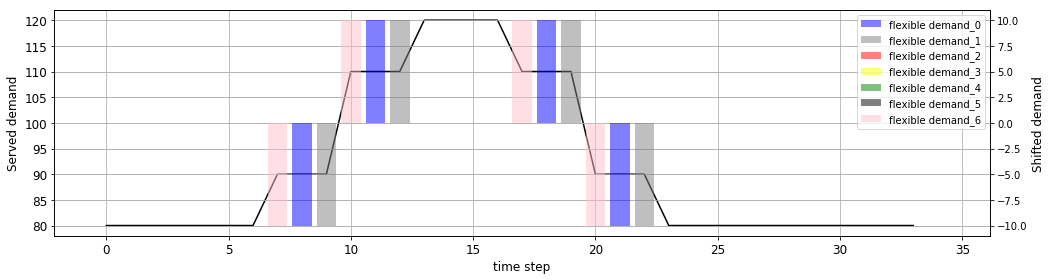

In [14]:
fig, axT = fn.plotOperation(esM_with,'flexible demand','location',figsize=(14,4),ylabel='Served demand')

ax = axT.twinx() 

#fig, ax = plt.subplots(1,1,figsize=(14,4))
color_1 = ['blue','grey','red','yellow','green','black','pink']
marker = ['o','x','*']

ax.grid(zorder=-10)

bottom_1 = np.array([0 for i in range(len(c.columns))])
bottom_2 = np.array([0 for i in range(len(c.columns))])

max1, max2 = 0, 0
for h in range(len(c.columns)):
    for i in range(tFwd + tBwd + 1):
        bottom = 0
        if (tFwd + h) % (tFwd + tBwd + 1) == i:
            chargeMax = esM_with.getComponent('flexible demand_' + str(i)).fullChargeOpRateMax.loc[(0,h),'location']
            if h == 0:
                ax.bar([h], chargeMax-c.iloc[i].values[h], color=color_1[i], zorder=10, 
                       label='flexible demand_' + str(i), alpha=0.5)
            else:
                ax.bar([h], chargeMax-c.iloc[i].values[h], color=color_1[i], zorder=10, alpha=0.5)
            if chargeMax-c.iloc[i].values[h] > max1:
                max1 = chargeMax-c.iloc[i].values[h]
        else:
            if h == 0:
                ax.bar([h], -c.iloc[i].values[h], bottom=[-bottom], color=color_1[i], zorder=10,
                       label='flexible demand_' + str(i), alpha=0.5)
            else:
                ax.bar([h], -c.iloc[i].values[h], bottom=[-bottom], color=color_1[i], zorder=10, alpha=0.5)
            if c.iloc[i].values[h] + bottom > max2:
                max2 = c.iloc[i].values[h]
            bottom += c.iloc[i].values[h]
            
max3=0

ax.legend()
ax.set_ylim([-max(max1,max2,max3)*1.1,max(max1,max2,max3)*1.1])
ax.set_ylabel('Shifted demand', fontsize=12)
plt.show()